In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
from vcs2425 import ApplyColormap, evaluate_topk, load_dataset_splits

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

color_map_transform = ApplyColormap(cmap='viridis')

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    color_map_transform,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    color_map_transform,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [2]:
# 4. Load full dataset
_, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 64

# 7. DataLoaders
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
)

# Evaluating "as-is"

In [3]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
top_1s = []
top_5s = []

colormaps = ['stacked', 'gray', 'viridis', 'plasma', 'magma', 'Spectral']
criterion = nn.CrossEntropyLoss()

for cmap in tqdm(colormaps, desc="Evaluating on different colormaps"):
    color_map_transform.cmap = cmap

    top_1 = evaluate_topk(model, val_loader, k=1, device=device)
    top_5 = evaluate_topk(model, val_loader, k=5, device=device)
    
    top_1s.append(top_1)
    top_5s.append(top_5)
    
    print(f"Colormap: {cmap}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")



Evaluating on different colormaps:  17%|█▋        | 1/6 [01:41<08:26, 101.28s/it]

Colormap: stacked, Top-1 Accuracy: 0.1318, Top-5 Accuracy: 0.2816


Evaluating on different colormaps:  33%|███▎      | 2/6 [03:35<07:16, 109.05s/it]

Colormap: gray, Top-1 Accuracy: 0.1327, Top-5 Accuracy: 0.2816


Evaluating on different colormaps:  50%|█████     | 3/6 [05:28<05:32, 110.94s/it]

Colormap: viridis, Top-1 Accuracy: 0.0656, Top-5 Accuracy: 0.1623


Evaluating on different colormaps:  67%|██████▋   | 4/6 [07:22<03:44, 112.07s/it]

Colormap: plasma, Top-1 Accuracy: 0.0583, Top-5 Accuracy: 0.1400


Evaluating on different colormaps:  83%|████████▎ | 5/6 [09:16<01:52, 112.59s/it]

Colormap: magma, Top-1 Accuracy: 0.0971, Top-5 Accuracy: 0.2144


Evaluating on different colormaps: 100%|██████████| 6/6 [11:11<00:00, 111.99s/it]

Colormap: Spectral, Top-1 Accuracy: 0.0570, Top-5 Accuracy: 0.1390


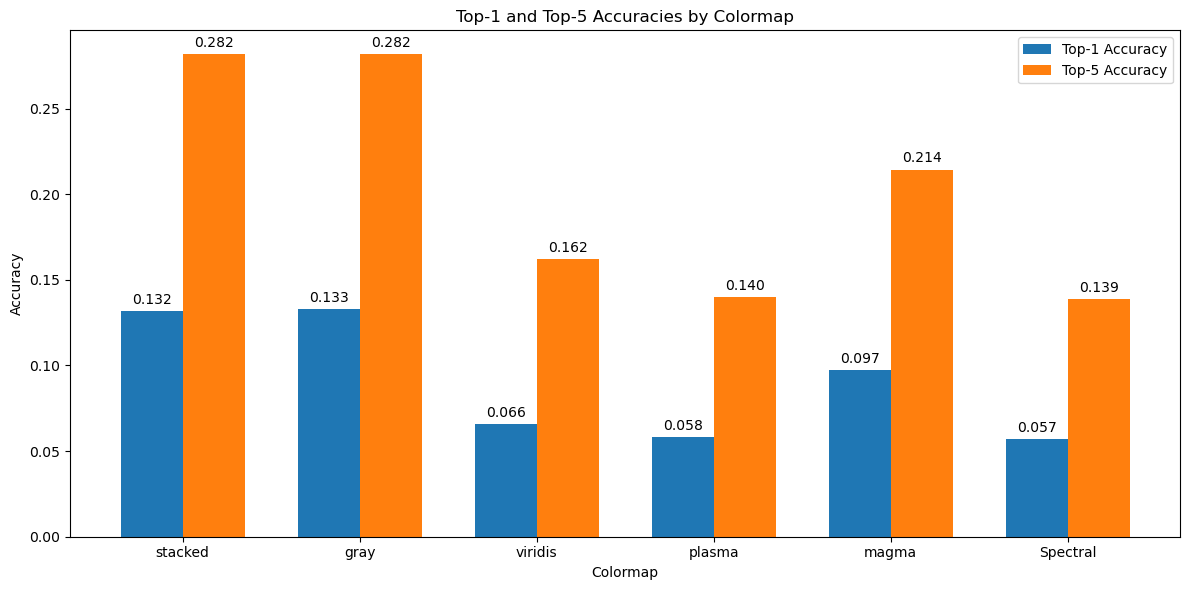

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure for the grid
fig, ax = plt.subplots(figsize=(12, 6))

# Set up bar width and positions
x = np.arange(len(colormaps))
width = 0.35

# Create bars
rects1 = ax.bar(x - width/2, top_1s, width, label='Top-1 Accuracy')
rects2 = ax.bar(x + width/2, top_5s, width, label='Top-5 Accuracy')

# Add labels, title and legend
ax.set_xlabel('Colormap')
ax.set_ylabel('Accuracy')
ax.set_title('Top-1 and Top-5 Accuracies by Colormap')
ax.set_xticks(x)
ax.set_xticklabels(colormaps)
ax.legend()

# Add text labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()